In [20]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import math
import warnings

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [12]:
## following formula here: 
## https://en.wikipedia.org/wiki/Haversine_formula

def get_haversine_distance_from_dc(coord):
    earth_rad = 6371 #earth rad in km
    
    lat_1 = 38.8899 #dc lat in degress north
    long_1 = -77.0091 #dc long in degrees east
    lat_2 = coord.y
    long_2 = coord.x #Need 
    
    
    #haversine = distance between 2 points on a sphere
        
    lat_1 = lat_1 * math.pi/180
    lat_2 = lat_2 * math.pi/180
    
    lat_delta = (lat_2 - lat_1) * math.pi/180
    long_delta = (long_2-long_1) * math.pi/180
    
    a = (pow(math.sin(lat_delta/2), 2) + 
         pow(math.sin(long_delta/2), 2) *
             math.cos(lat_1) * math.cos(lat_2))
    
    c = 2 * math.asin(math.sqrt(a))
    
    d = earth_rad * c #d is distance km
    
    return d

In [13]:
def get_csv(chamber, congress):
    fpath = '../congress-data/%s/%s_%d.csv' % (chamber, chamber, congress)
    cong_df = pd.read_csv(fpath, index_col=0)
    cong_df = cong_df.reset_index()
    
    cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
    
    if chamber == 'house':
        inds = cong_df['at_large'] == True
        cong_df.loc[inds, 'district'] = '0'
    
    return cong_df

def get_shapefile(chamber, congress):
    if chamber == 'house' and congress < 115:
        fpath = '../congress-data/shapefiles/districtShapes%d/districts%d.shp' % (congress, congress)
        map_df = gpd.read_file(fpath)
    elif chamber == 'house' and congress == 115:
        fpath = '../congress-data/shapefiles/cb_2016_us_cd115_500k/cb_2016_us_cd115_500k.shp'
        districts = gpd.read_file(fpath)  
        
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        states = gpd.read_file(fpath) 
        
        map_df = states[['STATEFP', 'NAME']].merge(districts, how='inner', left_on='STATEFP', right_on='STATEFP')
        
        map_df = gpd.GeoDataFrame(map_df)
        
        map_df['STATENAME'] = map_df['NAME']
        map_df['DISTRICT'] = map_df['CD115FP']

    elif chamber == 'house' and congress == 116:
        fpath = '../congress-data/shapefiles/cb_2018_us_cd116_500k/cb_2018_us_cd116_500k.shp'
        districts = gpd.read_file(fpath)    
        
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        states = gpd.read_file(fpath)
        
        map_df = states[['STATEFP', 'NAME']].merge(districts, how='inner', left_on='STATEFP', right_on='STATEFP')
        
        map_df = gpd.GeoDataFrame(map_df)

        map_df['STATENAME'] = map_df['NAME']
        map_df['DISTRICT'] = map_df['CD116FP']
    else:
        fpath = '../congress-data/shapefiles/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
        map_df = gpd.read_file(fpath)    
        map_df['STATENAME'] = map_df['NAME']
        
    return map_df

def get_merged_df(chamber, congress):
    map_df = get_shapefile(chamber, congress)
    cong_df = get_csv(chamber, congress)
    
    if chamber == 'house':
        left_on = ['STATENAME', 'DISTRICT']
        right_on = ['state_names', 'district']
    else:
        left_on = ['STATENAME']
        right_on = ['state_names']
    
    merged = map_df.merge(cong_df, how='inner', left_on=left_on, right_on=right_on)

    return merged

In [16]:
def plot_distance_vs_missed_votes_all_sessions(chamber, lower, upper):
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_xlabel('Distance From Capitol Building (km)')
    ax.set_ylabel('# Of Missed Votes')
    ax.set_title('Distance vs. Missed Votes for the %s' % (chamber))

    for session in range(lower, upper+1):
        merged = get_merged_df(chamber=chamber, congress=session)
        merged['distance_from_dc'] = merged.centroid.apply(get_haversine_distance_from_dc)
        distance = merged['distance_from_dc']
        missed = merged['missed_votes']
        
        ax.scatter(distance, missed, alpha=0.5, c='#64b5f6')
        

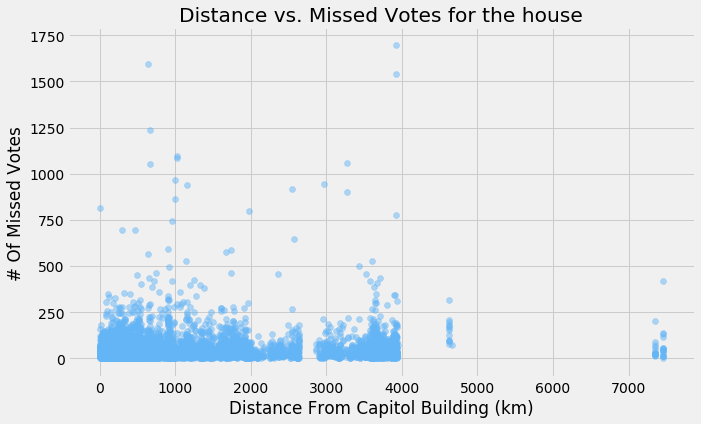

In [21]:
plot_distance_vs_missed_votes_all_sessions('house', lower=102, upper=116)

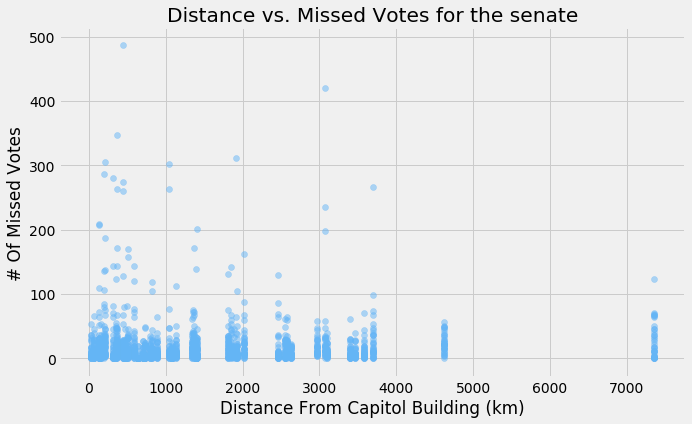

In [22]:
plot_distance_vs_missed_votes_all_sessions('senate', lower=101, upper=116)